In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
import tensorflowjs as tfjs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(tf.config.list_physical_devices('GPU'))

[]


In [38]:
# Constants
BATCH_SIZE = 32
LR = 1e-4

In [39]:
df = pd.read_csv('champions.csv')
def get_champ_vec(champ_name):
    arr = []
    row = df.loc[df['Champion'] == champ_name].iloc[0]
    for i in range(1, 16):
        if i == 7:
            if row[i] == 1:
                arr.append(1)
                arr.append(0)
                arr.append(0)
            elif row[i] == 2:
                arr.append(0)
                arr.append(1)
                arr.append(0)
            elif row[i] == 3:
                arr.append(0)
                arr.append(0)
                arr.append(1)
        else:
            arr.append(row[i] / 10)
    return arr

In [40]:
import random
def process_match(match):
    champs = match.split(',')
    vec = []
    for i in range(10):
        champ_vec = get_champ_vec(champs[i])
        for e in champ_vec:
            vec.append(e)
    if champs[10] == 'true':
        vec.append(1)
    else:
        vec.append(0)
    return vec

In [41]:
def process_ds_element(x):
    return (tf.cast(x[:-1], 'float32'), tf.cast(x[-1], 'int32'))

In [42]:
def get_dataset(num_games):
    tmp = []
    with open('data/matches/diamond_training_data.txt', 'r') as f:
        matches = f.read().split('\n')
        num_games = min(len(matches), num_games)
        for i in range(num_games):
            try:
                tmp.append(process_match(matches[i]))
            except:
                num_games -= 1
    ds = tf.data.Dataset.from_tensor_slices(tmp)
    ds = ds.map(process_ds_element)
    ds = ds.cache()
    ds = ds.shuffle(num_games)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    print(f'Using {num_games} matches for training')
    return ds

In [43]:
ds = get_dataset(10000)

Using 10000 matches for training


In [44]:
# Partition Dataset
train_size = int(len(ds)*0.8)
val_size = int(len(ds)*0.1)
test_size = len(ds) - (train_size + val_size)

train = ds.take(train_size)
val = ds.skip(train_size).take(val_size)
test = ds.skip(train_size+val_size).take(test_size)
print(train_size, val_size, test_size)

250 31 32


In [75]:
example = next(iter(train))
example

(<tf.Tensor: shape=(32, 170), dtype=float32, numpy=
 array([[0.5, 0.8, 0.6, ..., 0.2, 0.8, 0.8],
        [0.2, 0.7, 0.2, ..., 0.3, 0. , 0.3],
        [0.6, 0.7, 0.7, ..., 0.7, 0.6, 0.1],
        ...,
        [0.4, 0.9, 0.3, ..., 0.9, 0. , 0. ],
        [0.2, 0.4, 0. , ..., 0.5, 0.8, 0.6],
        [0.6, 0.7, 0.7, ..., 0.6, 1. , 0. ]], dtype=float32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 0])>)

In [76]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Dense(128, activation='sigmoid', input_dim=170))
    model.add(layers.Dense(64, activation='sigmoid'))
    model.add(layers.Dense(16, activation='sigmoid'))
    model.add(layers.Dense(1))
    return model

In [77]:
model = create_model()

In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               21888     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 31,201
Trainable params: 31,201
Non-trainable params: 0
_________________________________________________________________


In [79]:
loss = losses.BinaryCrossentropy(from_logits=True)
optimizer = optimizers.Adam(learning_rate=LR)
model.compile(loss=loss, optimizer=optimizer, metrics=[tf.metrics.BinaryAccuracy(thresho)])

In [80]:
history = model.fit(train, validation_data=val, epochs=100)

Epoch 1/100
250/250 [==============================] - 0s 1ms/step - loss: 0.6965 - binary_accuracy: 0.5034 - val_loss: 0.6930 - val_binary_accuracy: 0.5060
Epoch 2/100
250/250 [==============================] - 0s 795us/step - loss: 0.6933 - binary_accuracy: 0.5081 - val_loss: 0.6929 - val_binary_accuracy: 0.5081
Epoch 3/100
250/250 [==============================] - 0s 779us/step - loss: 0.6934 - binary_accuracy: 0.5001 - val_loss: 0.6930 - val_binary_accuracy: 0.5020
Epoch 4/100
250/250 [==============================] - 0s 815us/step - loss: 0.6932 - binary_accuracy: 0.5070 - val_loss: 0.6923 - val_binary_accuracy: 0.5181
Epoch 5/100
250/250 [==============================] - 0s 848us/step - loss: 0.6931 - binary_accuracy: 0.4994 - val_loss: 0.6924 - val_binary_accuracy: 0.4859
Epoch 6/100
250/250 [==============================] - 0s 803us/step - loss: 0.6931 - binary_accuracy: 0.5066 - val_loss: 0.6924 - val_binary_accuracy: 0.5181
Epoch 7/100
250/250 [===========================

250/250 [==============================] - 0s 778us/step - loss: 0.6872 - binary_accuracy: 0.5048 - val_loss: 0.6817 - val_binary_accuracy: 0.5091
Epoch 53/100
250/250 [==============================] - 0s 795us/step - loss: 0.6874 - binary_accuracy: 0.5060 - val_loss: 0.6879 - val_binary_accuracy: 0.5161
Epoch 54/100
250/250 [==============================] - 0s 779us/step - loss: 0.6875 - binary_accuracy: 0.5034 - val_loss: 0.6896 - val_binary_accuracy: 0.5040
Epoch 55/100
250/250 [==============================] - 0s 779us/step - loss: 0.6873 - binary_accuracy: 0.5055 - val_loss: 0.6844 - val_binary_accuracy: 0.5151
Epoch 56/100
250/250 [==============================] - 0s 799us/step - loss: 0.6864 - binary_accuracy: 0.5026 - val_loss: 0.6814 - val_binary_accuracy: 0.5081
Epoch 57/100
250/250 [==============================] - 0s 779us/step - loss: 0.6875 - binary_accuracy: 0.5031 - val_loss: 0.6815 - val_binary_accuracy: 0.5333
Epoch 58/100
250/250 [==============================]

In [81]:
history_dict = history.history

In [82]:
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

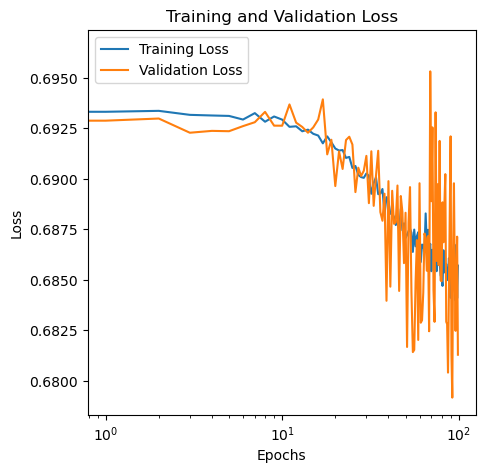

In [83]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.show()

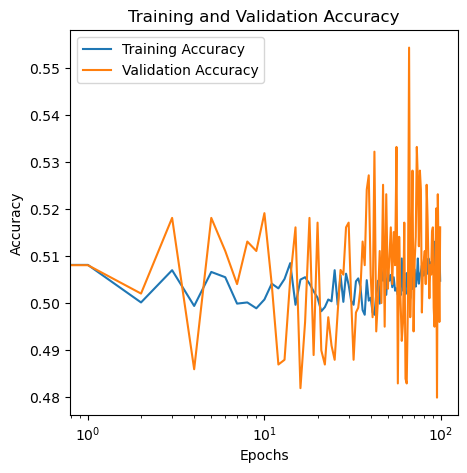

In [84]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['binary_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [85]:
loss, accuracy = model.evaluate(test)
print('Loss:', loss)
print('Accuracy:', accuracy)

32/32 [==============================] - 0s 516us/step - loss: 0.6831 - binary_accuracy: 0.5298
Loss: 0.6830502152442932
Accuracy: 0.5297619104385376


In [36]:
# Save the model
export_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Activation('sigmoid')
])

In [36]:
tfjs.converters.save_keras_model(export_model, 'winpredictor/public/models/master')